<a href="https://colab.research.google.com/github/Saul-Ochoa/ClasificaciOn-de-PredicciOn-Salarial/blob/main/Forecasting/stocks-shares/AAPL_Close_MS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series de Tiempo Frecuencia Mensual



In [82]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Descargar datos de yahoo
import yfinance as yf
from yahoofinancials import YahooFinancials

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from timeit import default_timer as timer

#import warnings
import warnings
warnings.filterwarnings('ignore')

In [118]:
# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

In [108]:
df = yf.download("AApl", 
                      start='2012-01-01', 
                      end='2022-03-28', 
                      progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500192,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567369,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706894,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839728,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819362,394024400


In [109]:
df.to_csv("fb.csv")

In [110]:
data = pd.read_csv("fb.csv")[["Date","Close"]]
data["Date"] = pd.to_datetime(data["Date"], format = "%Y-%m-%d")

data = data.set_index("Date")
data = data.asfreq('MS')
#data = data['Close']
data = data.sort_index()
data.head()

,Close
Date,
2012-02-01,16.292500
2012-03-01,19.445356
2012-04-01,NaN
2012-05-01,20.790358
2012-06-01,20.035357


In [111]:
data.isnull().sum()

Close    44
dtype: int64

In [112]:
data=data.fillna(method='ffill')

In [113]:
data.isnull().sum()

Close    0
dtype: int64

In [114]:
data.head()

,Close
Date,
2012-02-01,16.292500
2012-03-01,19.445356
2012-04-01,19.445356
2012-05-01,20.790358
2012-06-01,20.035357


In [115]:
data.shape

(122, 1)

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2012-02-01 to 2022-03-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   122 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [119]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [120]:
Prueba_Dickey_Fuller(data["Close"],"Close")

Resultados de la prueba de Dickey-Fuller para columna: Close
Test Statistic                          2.579286
p-value                                 0.999071
No Lags Used                            1.000000
Número de observaciones utilizadas    120.000000
Critical Value (1%)                    -3.486056
Critical Value (5%)                    -2.885943
Critical Value (10%)                   -2.579785
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


In [121]:
data1=data.copy()
data1['Close_diff']=df['Close'].diff()
data1.dropna(inplace=True)
data1.head()

,Close,Close_diff
Date,,
2012-02-01,16.292500,-0.010357
2012-03-01,19.445356,0.072500
2012-05-01,20.790358,-0.066071
2012-06-01,20.035357,-0.597858
2012-08-01,21.671785,-0.141071


In [122]:
Prueba_Dickey_Fuller(data1["Close_diff"],"Close_diff")

Resultados de la prueba de Dickey-Fuller para columna: Close_diff
Test Statistic                        -4.022721
p-value                                0.001296
No Lags Used                           1.000000
Número de observaciones utilizadas    76.000000
Critical Value (1%)                   -3.519481
Critical Value (5%)                   -2.900395
Critical Value (10%)                  -2.587498
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


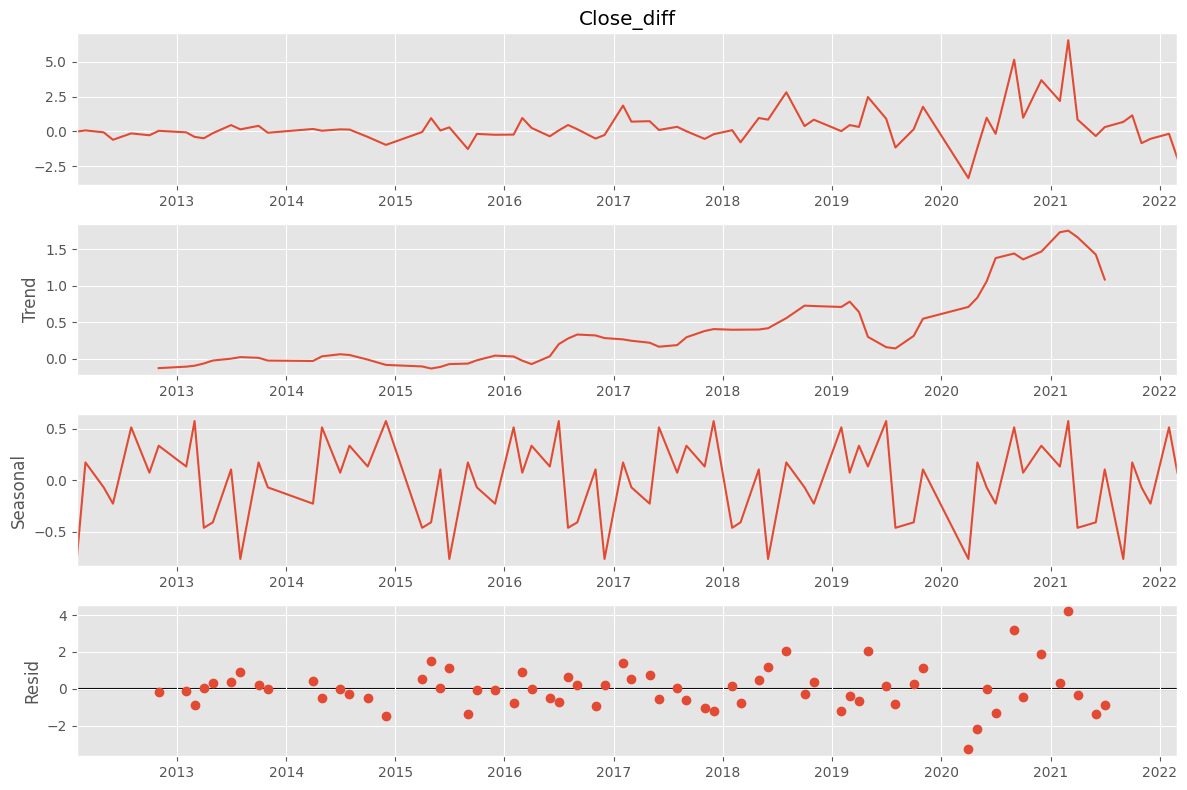

In [126]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(data1["Close_diff"], model = "add",period=12)
a.plot()
plt.show()

In [127]:
train_data = data[:len(data)-12]
test_data = data[len(data)-12:]
test=test_data.copy()

In [128]:
train_data.shape, test_data.shape

((110, 1), (12, 1))

In [129]:
test_data

,Close
Date,
2021-04-01,123.000000
2021-05-01,123.000000
2021-06-01,124.279999
2021-07-01,137.270004
2021-08-01,137.270004
2021-09-01,152.509995
2021-10-01,142.649994
2021-11-01,148.960007
2021-12-01,164.770004


In [130]:
# Modelo Auto-Arima
from pmdarima import auto_arima  

In [131]:
modelo_auto=auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=637.507, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=633.309, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=629.801, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=633.894, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=631.674, Time=0.86 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=631.014, Time=0.58 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=633.681, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=631.773, Time=0.82 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=634.145, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=630.870, Time=0.37 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=630.319, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=628.894, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=633.935, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=630.837, Time=0.41 sec
 ARIMA(1,1,0)(0,1,2)[12]         

In [132]:
print(modelo_auto.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  110
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -309.232
Date:                              Wed, 12 Apr 2023   AIC                            626.465
Time:                                      21:33:50   BIC                            636.763
Sample:                                  02-01-2012   HQIC                           630.629
                                       - 03-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6055      0.328      1.846      0.065      -0.037       1.248
ar.L1         -0.30

In [133]:
arima_model = SARIMAX(train_data["Close"], order = (1,1,0), seasonal_order = (0,1,1,12)) 
arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  110
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -311.447
Date:                              Wed, 12 Apr 2023   AIC                            628.894
Time:                                      21:34:34   BIC                            636.618
Sample:                                  02-01-2012   HQIC                           632.017
                                       - 03-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2694      0.073     -3.696      0.000      -0.412      -0.127
ma.S.L12      -0.5510      0.234     -2.356      0.018      -1.009      -0.093
sigma2        34.4030      1.320     26.060      0.000      31.815      36.990
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              2894.15
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):              26.01   Skew:                             3.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

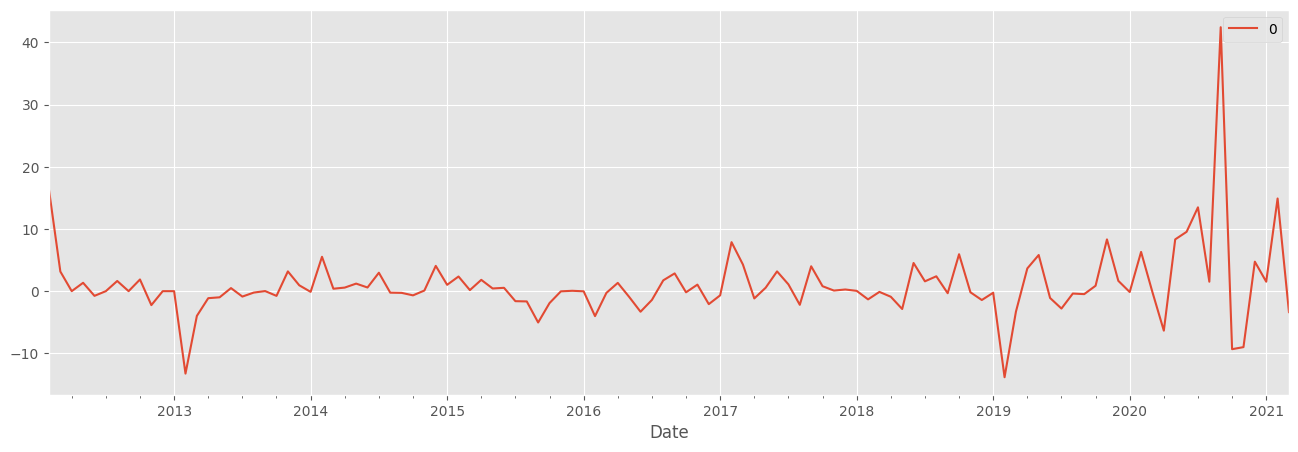

In [134]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5))
plt.show()

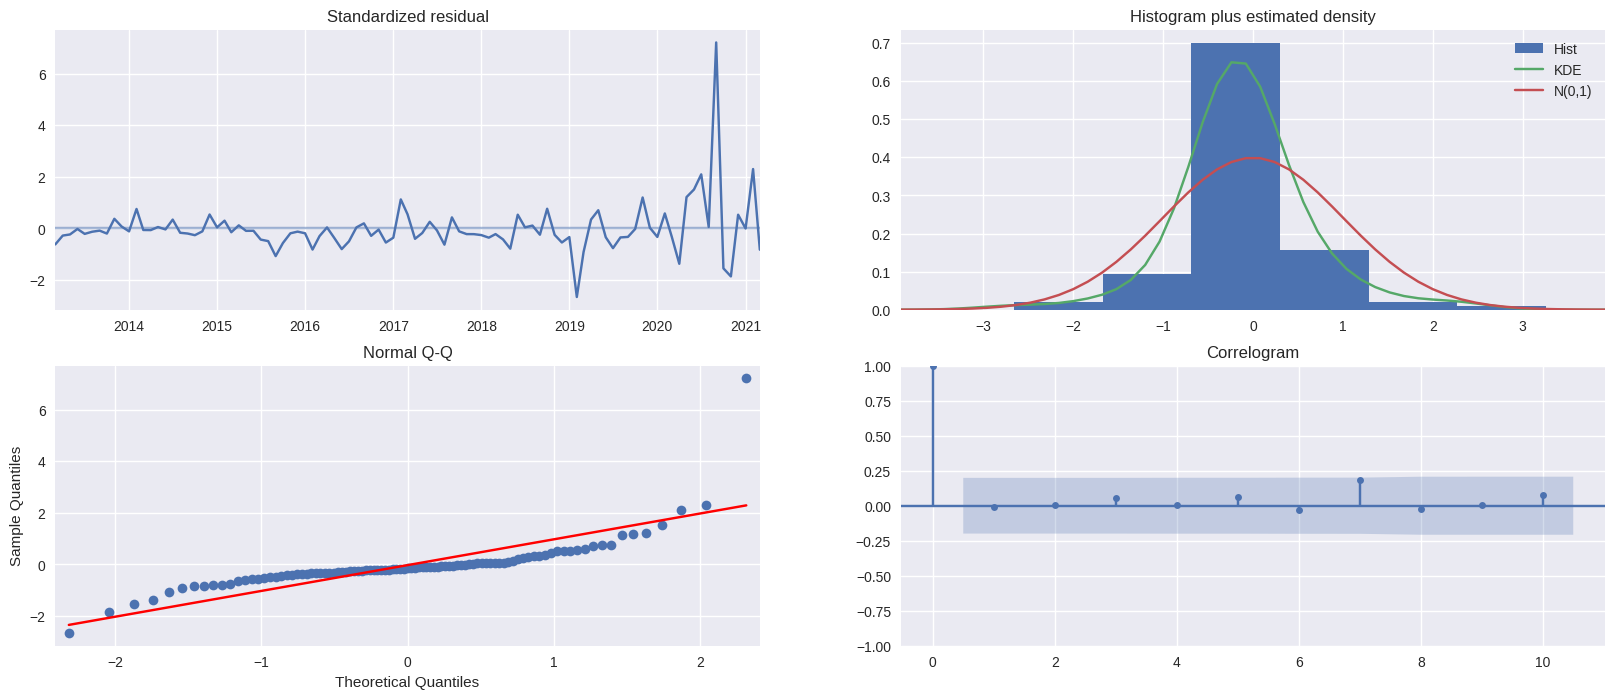

In [135]:
plt.style.use('seaborn')
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

In [136]:
arima_pred = arima_result.predict(start = len(train_data), end = len(data)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-04-01    129.272538
2021-05-01    135.323547
2021-06-01    139.877130
2021-07-01    143.998553
2021-08-01    144.897312
2021-09-01    164.430648
2021-10-01    158.542375
2021-11-01    160.401091
2021-12-01    163.218300
2022-01-01    163.219065
2022-02-01    166.431943
2022-03-01    164.149140
Freq: MS, Name: ARIMA Predictions, dtype: float64

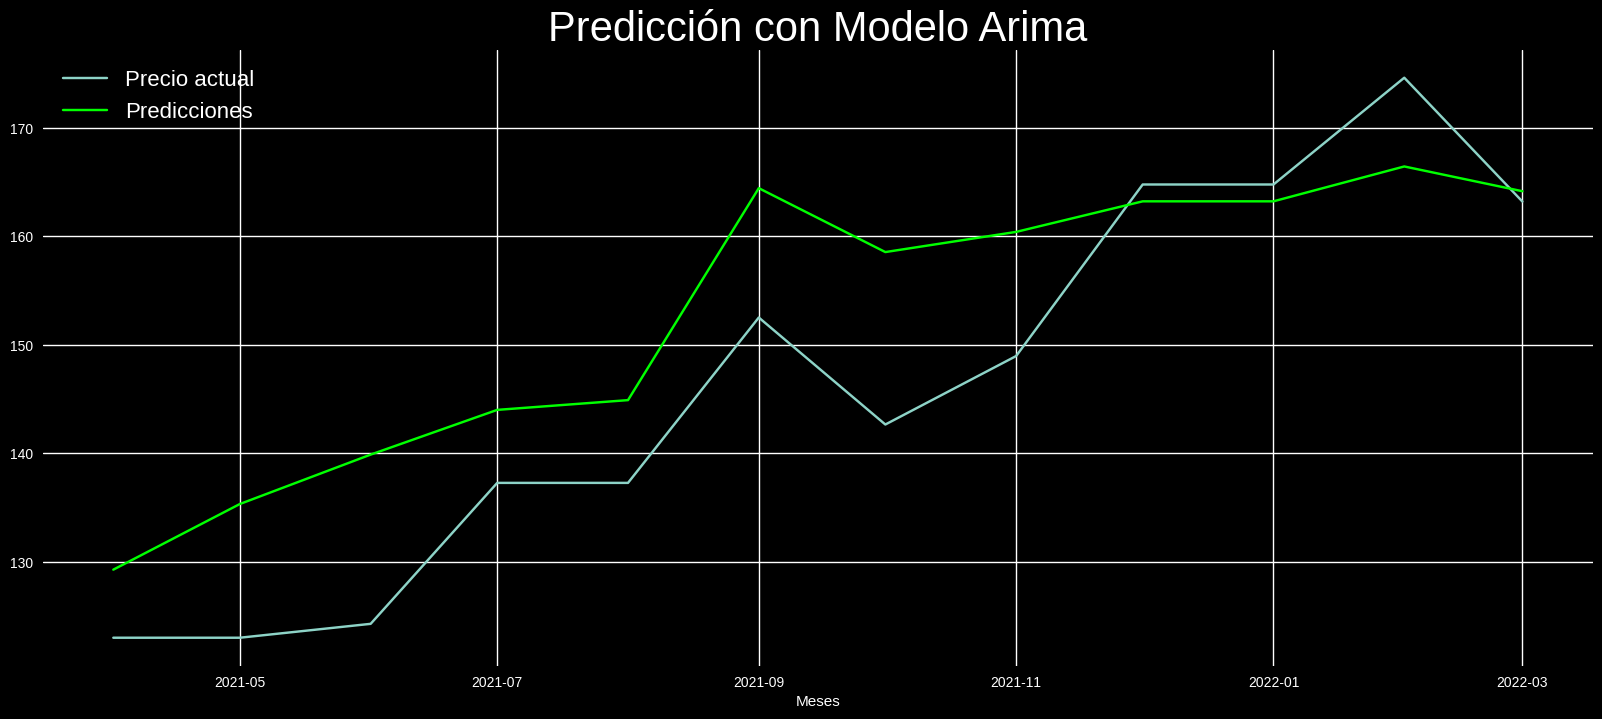

In [138]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["Close"], label="Precio actual")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [140]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [141]:
evaluacion_metrica(test_data,arima_pred)

Evaluation metric results:-
MSE is : 94.67475823563446
MAE is : 8.336086320140856
RMSE is : 9.730095489543483
MAPE is : 13.05989397363782
R2 is : 0.6810519309786625



In [142]:
test_data['ARIMA_Predictions'] = arima_pred

In [143]:
test_data

,Close,ARIMA_Predictions
Date,,
2021-04-01,123.000000,129.272538
2021-05-01,123.000000,135.323547
2021-06-01,124.279999,139.877130
2021-07-01,137.270004,143.998553
2021-08-01,137.270004,144.897312
2021-09-01,152.509995,164.430648
2021-10-01,142.649994,158.542375
2021-11-01,148.960007,160.401091
2021-12-01,164.770004,163.218300


## LSTM Forecast

In [260]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [261]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

scaled_test_data = scaler.transform(test)

In [262]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [263]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [264]:
lstm_model.fit_generator(generator,epochs=100)

Epoch 1/100
98/98 [==============================] - 5s 22ms/step - loss: 0.0124
Epoch 2/100
98/98 [==============================] - 2s 23ms/step - loss: 0.0077
Epoch 3/100
98/98 [==============================] - 1s 12ms/step - loss: 0.0089
Epoch 4/100
98/98 [==============================] - 1s 14ms/step - loss: 0.0067
Epoch 5/100
98/98 [==============================] - 3s 26ms/step - loss: 0.0048
Epoch 6/100
98/98 [==============================] - 2s 22ms/step - loss: 0.0053
Epoch 7/100
98/98 [==============================] - 1s 12ms/step - loss: 0.0063
Epoch 8/100
98/98 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 9/100
98/98 [==============================] - 1s 12ms/step - loss: 0.0039
Epoch 10/100
98/98 [==============================] - 2s 15ms/step - loss: 0.0047
Epoch 11/100
98/98 [==============================] - 3s 27ms/step - loss: 0.0036
Epoch 12/100
98/98 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 13/100
98/98 [=====

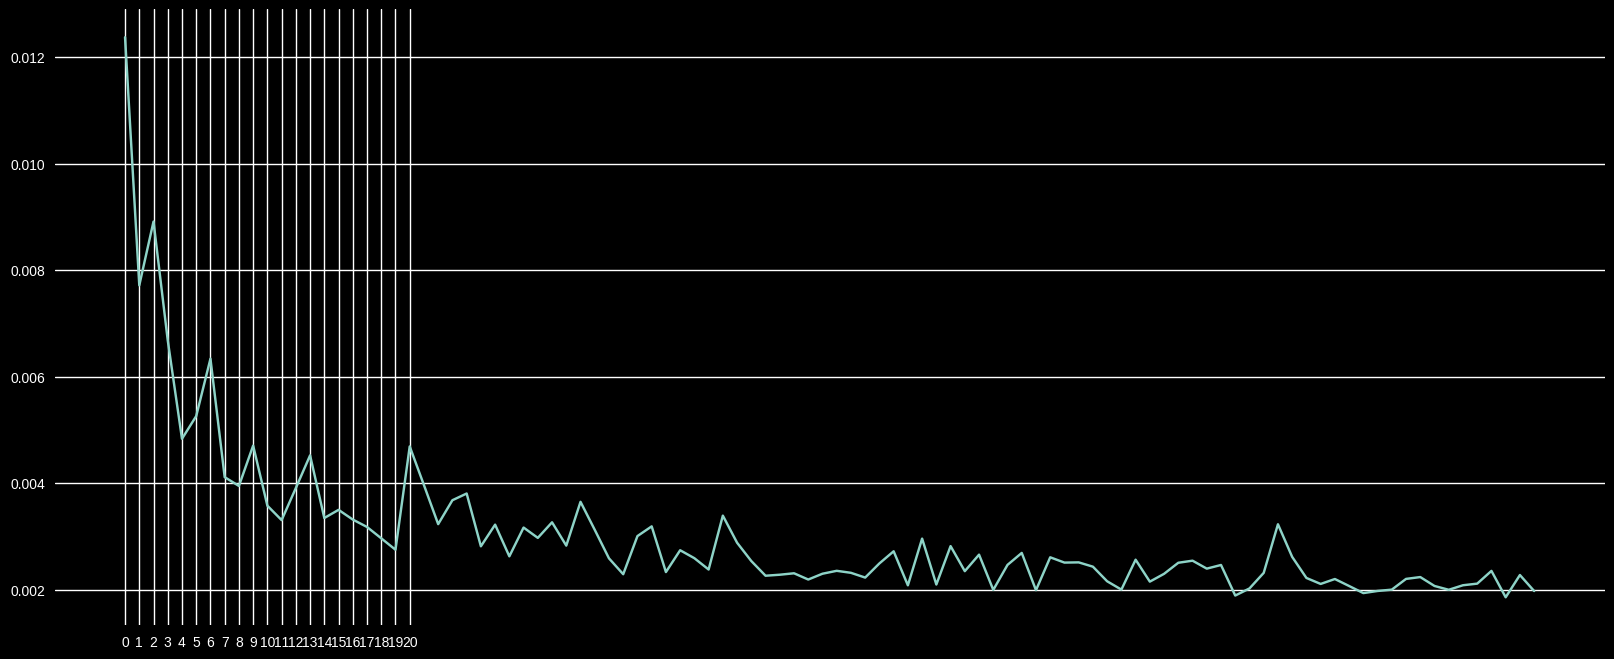

In [265]:
losses_lstm = lstm_model.history.history['loss']
#plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

In [266]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [267]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [268]:
lstm_predictions

array([[135.12857549],
       [137.45269747],
       [139.73850668],
       [141.38843531],
       [142.52900951],
       [143.26273871],
       [143.80973599],
       [144.17085653],
       [144.40579298],
       [144.55568024],
       [144.6506497 ],
       [144.72723245]])

In [269]:
test_data['LSTM_Predictions'] = lstm_predictions

In [270]:
test_data

,Close,ARIMA_Predictions,Prophet_Predictions,LSTM_Predictions
Date,,,,
2021-04-01,123.000000,129.272538,113.601314,135.128575
2021-05-01,123.000000,135.323547,118.242427,137.452697
2021-06-01,124.279999,139.877130,121.373145,139.738507
2021-07-01,137.270004,143.998553,124.193934,141.388435
2021-08-01,137.270004,144.897312,126.829879,142.529010
2021-09-01,152.509995,164.430648,134.768457,143.262739
2021-10-01,142.649994,158.542375,135.030531,143.809736
2021-11-01,148.960007,160.401091,137.222032,144.170857
2021-12-01,164.770004,163.218300,140.571587,144.405793


## Random Forest

In [239]:
df5 = data.copy()
df5.head()

,Close
Date,
2012-02-01,16.292500
2012-03-01,19.445356
2012-04-01,19.445356
2012-05-01,20.790358
2012-06-01,20.035357


In [240]:
df5=df5.reset_index()

In [241]:
df5['furniture_pct_change']= df5['Close'].pct_change()
df5.dropna(inplace=True)
df5.head()

,Date,Close,furniture_pct_change
1,2012-03-01,19.445356,0.193516
2,2012-04-01,19.445356,0.000000
3,2012-05-01,20.790358,0.069168
4,2012-06-01,20.035357,-0.036315
5,2012-07-01,20.035357,0.000000


In [242]:
df5['furniture_pct_change'].describe()

count    121.000000
mean       0.022519
std        0.083136
min       -0.250652
25%        0.000000
50%        0.000000
75%        0.065723
max        0.474060
Name: furniture_pct_change, dtype: float64

In [243]:
fig = px.line(df5, x="Date", y="furniture_pct_change",template = "plotly_dark",
              title="Porcentaje de Cambio")
fig.show()

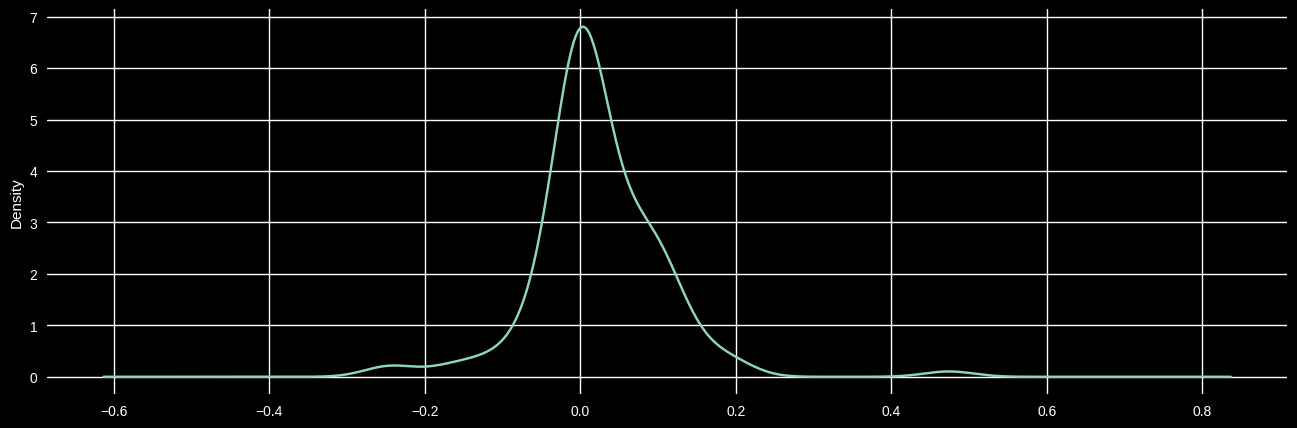

In [244]:
df5['furniture_pct_change'].plot(kind='kde',figsize = (16,5));

In [245]:
# Variables de estacionalidad
df5['Date'] = pd.to_datetime(df5['Date'])
df5['Year'] = df5['Date'].apply(lambda x: x.year)
df5['Mes'] = df5['Date'].apply(lambda x: x.month)
df5.head()

,Date,Close,furniture_pct_change,Year,Mes
1,2012-03-01,19.445356,0.193516,2012,3
2,2012-04-01,19.445356,0.000000,2012,4
3,2012-05-01,20.790358,0.069168,2012,5
4,2012-06-01,20.035357,-0.036315,2012,6
5,2012-07-01,20.035357,0.000000,2012,7


In [246]:
# Agregar un año de datos retrasados
df5['L1'] = df5["furniture_pct_change"].shift(1)
df5['L2'] = df5["furniture_pct_change"].shift(2)
df5['L3'] = df5["furniture_pct_change"].shift(3)
df5['L4'] = df5["furniture_pct_change"].shift(4)
df5['L5'] = df5["furniture_pct_change"].shift(5)
df5['L6'] = df5["furniture_pct_change"].shift(6)
df5['L7'] = df5["furniture_pct_change"].shift(7)
df5['L8'] = df5["furniture_pct_change"].shift(8)
df5['L9'] = df5["furniture_pct_change"].shift(9)
df5['L10'] = df5["furniture_pct_change"].shift(10)
df5['L11'] = df5["furniture_pct_change"].shift(11)
df5['L12'] = df5["furniture_pct_change"].shift(12)

In [247]:
df5.head(13)

,Date,Close,furniture_pct_change,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
1,2012-03-01,19.445356,0.193516,2012,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-04-01,19.445356,0.000000,2012,4,0.193516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-05-01,20.790358,0.069168,2012,5,0.000000,0.193516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-06-01,20.035357,-0.036315,2012,6,0.069168,0.000000,0.193516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2012-07-01,20.035357,0.000000,2012,7,-0.036315,0.069168,0.000000,0.193516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2012-08-01,21.671785,0.081677,2012,8,0.000000,-0.036315,0.069168,0.000000,0.193516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2012-09-01,21.671785,0.000000,2012,9,0.081677,0.000000,-0.036315,0.069168,0.000000,0.193516,NaN,NaN,NaN,NaN,NaN,NaN
8,2012-10-01,23.549643,0.086650,2012,10,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000,0.193516,NaN,NaN,NaN,NaN,NaN
9,2012-11-01,21.305000,-0.095315,2012,11,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000,0.193516,NaN,NaN,NaN,NaN
10,2012-12-01,21.305000,0.000000,2012,12,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000,0.193516,NaN,NaN,NaN


In [248]:
df5 = df5.dropna()
df5.head()

,Date,Close,furniture_pct_change,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
13,2013-03-01,15.373929,-0.051034,2013,3,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000,0.193516
14,2013-04-01,15.318214,-0.003624,2013,4,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000
15,2013-05-01,15.688929,0.024201,2013,5,-0.003624,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168
16,2013-06-01,15.688929,0.000000,2013,6,0.024201,-0.003624,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315
17,2013-07-01,14.615000,-0.068451,2013,7,0.000000,0.024201,-0.003624,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000


In [249]:
df5= df5.set_index("Date")
df5.head()

,Close,furniture_pct_change,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
Date,,,,,,,,,,,,,,,,
2013-03-01,15.373929,-0.051034,2013,3,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000,0.193516
2013-04-01,15.318214,-0.003624,2013,4,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000
2013-05-01,15.688929,0.024201,2013,5,-0.003624,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168
2013-06-01,15.688929,0.000000,2013,6,0.024201,-0.003624,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315
2013-07-01,14.615000,-0.068451,2013,7,0.000000,0.024201,-0.003624,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000


In [250]:
# dividir en variables rezagadas (características) y datos de series de tiempo originales (objetivo)
X2= df5.iloc[:,2:] # dividir todas las filas y comenzar con la columna 0 y subir hasta la última columna, pero sin incluirla
y2 = df5.iloc[:,1] # dividir todas las filas y la última columna, esencialmente separando la columna 't'

In [251]:
X2.head(3)

,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
Date,,,,,,,,,,,,,,
2013-03-01,2013,3,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000,0.193516
2013-04-01,2013,4,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168,0.000000
2013-05-01,2013,5,-0.003624,-0.051034,-0.239582,0.000000,0.000000,-0.095315,0.086650,0.000000,0.081677,0.000000,-0.036315,0.069168


In [252]:
y2.head()

Date
2013-03-01   -0.051034
2013-04-01   -0.003624
2013-05-01    0.024201
2013-06-01    0.000000
2013-07-01   -0.068451
Name: furniture_pct_change, dtype: float64

In [253]:
# Target Train-Test split
from pandas import read_csv

Y2 = y2
traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observaciones para el objetivo: %d' % (len(Y2)))
print('Observaciones de entrenamiento para el objetivo: %d' % (len(train_target)))
print('Observaciones de prueba para el objetivo: %d' % (len(test_target)))

Observaciones para el objetivo: 109
Observaciones de entrenamiento para el objetivo: 87
Observaciones de prueba para el objetivo: 22


In [254]:
# Features Train-Test split

trainfeature_size = int(len(X2) * 0.80)
train_feature, test_feature = X2[0:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observaciones para la característica: %d' % (len(X2)))
print('Observaciones de entrenamiento para la característica: %d' % (len(train_feature)))
print('Observaciones de prueba para la característica: %d' % (len(test_feature)))

Observaciones para la característica: 109
Observaciones de entrenamiento para la característica: 87
Observaciones de prueba para la característica: 22


In [255]:
# Creando Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2,  shuffle=False)

In [256]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr = RandomForestRegressor(n_estimators=100)

# Entrenamos el modelo
rfr.fit(train_feature, train_target)

# Hacemos las predicciones 
fcst = rfr.predict(test_feature)

In [257]:
b=pd.DataFrame({"Actual":test_target, "Random Forest":fcst})
b

,Actual,Random Forest
Date,,
2020-06-01,0.113398,0.029503
2020-07-01,0.131303,-0.020085
2020-08-01,0.000000,0.012893
2020-09-01,0.474060,0.039307
2020-10-01,-0.129602,0.019574
2020-11-01,0.000000,0.063313
2020-12-01,0.050775,0.082136
2021-01-01,0.000000,-0.066086
2021-02-01,0.093057,-0.033468


In [258]:
fig = px.line(b, x=b.index, y=b.columns,template = "plotly_dark",
              title="Predicción con Modelo Random Forest")
fig.show()

In [259]:
evaluacion_metrica(test_target,fcst)

Evaluation metric results:-
MSE is : 0.014074357608637228
MAE is : 0.07960950458844997
RMSE is : 0.11863539778934966
MAPE is : inf
R2 is : -0.05417846326449971



##  Prophet Forecast

In [144]:
import pandas as pd
from prophet import Prophet

In [145]:
df6 = data.copy()
df6.head()

,Close
Date,
2012-02-01,16.292500
2012-03-01,19.445356
2012-04-01,19.445356
2012-05-01,20.790358
2012-06-01,20.035357


In [146]:
df6=df6.reset_index()

In [147]:
df_fb=df6.rename(columns={"Date":"ds", "Close":"y"} )
df_fb.head()

,ds,y
0,2012-02-01,16.292500
1,2012-03-01,19.445356
2,2012-04-01,19.445356
3,2012-05-01,20.790358
4,2012-06-01,20.035357


In [148]:
train_data_pr = df_fb.iloc[:len(df6)-12]
test_data_pr = df_fb.iloc[len(df6)-12:]

In [149]:
m = Prophet()

# Hacemos el entrenamiento
m.fit(train_data_pr)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ulld4wj/mxfkc6jy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ulld4wj/4sduzlil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46154', 'data', 'file=/tmp/tmp6ulld4wj/mxfkc6jy.json', 'init=/tmp/tmp6ulld4wj/4sduzlil.json', 'output', 'file=/tmp/tmp6ulld4wj/prophet_modelly6p1dca/prophet_model-20230412214737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [150]:
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [151]:
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-02-01,14.042339,1.323098,20.183120,14.042339,14.042339,-3.493112,-3.493112,-3.493112,-3.493112,-3.493112,-3.493112,0.0,0.0,0.0,10.549227
1,2012-03-01,14.301182,4.987654,23.200019,14.301182,14.301182,-0.350850,-0.350850,-0.350850,-0.350850,-0.350850,-0.350850,0.0,0.0,0.0,13.950332
2,2012-04-01,14.577877,2.380761,20.576202,14.577877,14.577877,-2.871837,-2.871837,-2.871837,-2.871837,-2.871837,-2.871837,0.0,0.0,0.0,11.706040
3,2012-05-01,14.845646,5.501350,23.910120,14.845646,14.845646,-0.049286,-0.049286,-0.049286,-0.049286,-0.049286,-0.049286,0.0,0.0,0.0,14.796361
4,2012-06-01,15.122341,5.679698,24.842596,15.122341,15.122341,0.138328,0.138328,0.138328,0.138328,0.138328,0.138328,0.0,0.0,0.0,15.260669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2021-11-01,134.630310,127.697372,146.978013,133.690016,135.485604,2.591722,2.591722,2.591722,2.591722,2.591722,2.591722,0.0,0.0,0.0,137.222032
118,2021-12-01,137.322179,130.570903,149.336187,136.181841,138.383178,3.249408,3.249408,3.249408,3.249408,3.249408,3.249408,0.0,0.0,0.0,140.571587
119,2022-01-01,140.103777,133.529512,151.898082,138.694004,141.396083,2.663380,2.663380,2.663380,2.663380,2.663380,2.663380,0.0,0.0,0.0,142.767157
120,2022-02-01,142.885375,135.516906,154.419103,141.194856,144.381245,2.324090,2.324090,2.324090,2.324090,2.324090,2.324090,0.0,0.0,0.0,145.209465


In [152]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [153]:
prophet_pred = prophet_pred.set_index("Date")

In [154]:
prophet_pred.index.freq = "MS"

In [155]:
prophet_pred

,Pred
Date,
2021-04-01,113.601314
2021-05-01,118.242427
2021-06-01,121.373145
2021-07-01,124.193934
2021-08-01,126.829879
2021-09-01,134.768457
2021-10-01,135.030531
2021-11-01,137.222032
2021-12-01,140.571587


In [156]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [157]:
test_data.head()

,Close,ARIMA_Predictions,Prophet_Predictions
Date,,,
2021-04-01,123.000000,129.272538,113.601314
2021-05-01,123.000000,135.323547,118.242427
2021-06-01,124.279999,139.877130,121.373145
2021-07-01,137.270004,143.998553,124.193934
2021-08-01,137.270004,144.897312,126.829879


In [158]:
a=test_data[["Close","Prophet_Predictions"]]
fig = px.line(a, x=test_data.index, y=a.columns,template = "plotly_dark",
              title="Predicción con Modelo Prophet")
fig.show()

In [160]:
evaluacion_metrica(test_data["Close"],test_data["Prophet_Predictions"])

Evaluation metric results:-
MSE is : 261.39798744657736
MAE is : 14.199041463900107
RMSE is : 16.167807131660663
MAPE is : 9.266215293171099
R2 is : 0.11938108006945725



In [271]:
fig = px.line(test_data, x=test_data.index, y=test_data.columns,template = "plotly_dark",
              title="Predicciones")
fig.show()

In [272]:
test_data

,Close,ARIMA_Predictions,Prophet_Predictions,LSTM_Predictions
Date,,,,
2021-04-01,123.000000,129.272538,113.601314,135.128575
2021-05-01,123.000000,135.323547,118.242427,137.452697
2021-06-01,124.279999,139.877130,121.373145,139.738507
2021-07-01,137.270004,143.998553,124.193934,141.388435
2021-08-01,137.270004,144.897312,126.829879,142.529010
2021-09-01,152.509995,164.430648,134.768457,143.262739
2021-10-01,142.649994,158.542375,135.030531,143.809736
2021-11-01,148.960007,160.401091,137.222032,144.170857
2021-12-01,164.770004,163.218300,140.571587,144.405793
